# Langgraph Chatbot With Tools

In [1]:
%pip install langchain langgraph langchain-openai langchain-community langchain-tavily -Uq

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")
os.environ['TAVILY_API_KEY'] = os.getenv("tavily_key")

## 도구 정의

In [ ]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=3)  # 검색결과 3개
tavily_tool.invoke('랭그래프에서 노드란 무엇인가요?')

{'query': '랭그래프에서 노드란 무엇인가요?',
 'response_time': 1.16,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://normalstory.tistory.com/entry/LangGraph-01',
   'title': 'LangGraph - 1. 개요 - 청춘만화 - 티스토리',
   'content': "***\\*지극히 주관적 개요:*** *Devika, Crew AI, phidata를 사용하면서 또는 사용할수록 강하게 느껴지는 점이 하나 있다면 지금 중요한 것은 ’ 프롬프트나 RAG가 아니라 얼마나 Agentic 한 LLM 애플리케이션을 얼마나 Locally 하게 구성할 수 있는가 ‘라고 생각한다.* *물론 이때 구성의 주체는 operater가 아니라 End-User이다. LangGraph는 Agent 런타임에 자주 필요한 '**주기적 그래프***workflows containing**cycles*'를 더 잘 생성할 수 있도록 LangChain 위에 구축된 모듈이다. 그리고 프로세스의 '방향'은 프로세스 내 워크의 상태(실행 여부나 그 상태) 정보를 기반으로 이뤄지는데 이러한 일련의 내용은 기본적으로 scratch 코딩과 같이\xa0그래프( workflows,\xa0diagram)형태로 표현될 수 있다. 2. 속성의 값을 추가하는 말 그대로 '업데이트'하는 방식이 있는데 이 경우 속성이 수행된 작업의 목록(또는 이와 유사한 것)인 경우 노드가 수행한 새로운 작업을 반환하고 해당 작업이 속성에 자동으로 추가되도록 하려는 경우 사용될 수 있다. 이때 노드는 다양한 형태(역할)로 정의될 수 있는데 하나의 체인처럼 생각할 수 있고, 실제로도 실행 가능하기 때문에 하나의 도구가 되거나 체인의 역할을 할 수도 있다. 그래프를 컴파일을 하기 전에 'entry point'역할을 하는 노드를 지정하고 'end point'를 세

## 그래프 구성

In [ ]:
from langchain.chat_models import init_chat_model
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages  # 메시지 누적 규칙
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# 상태 스키마
class State(TypedDict):
    messages: Annotated[List, add_messages]

llm = init_chat_model('gpt-4.1-mini')
tools = [tavily_tool]
llm_with_tools = llm.bind_tools(tools) # LLM에 도구 스펙 바인딩 (필요시 tool call 생성)


def chatbot(state: State):
    response: AIMessage = llm_with_tools.invoke(state['messages'])  # 도구호출 필요시 ToolCall 포함 응답 생성
    return {'messages': [response]}  # 응답 메시지를 상태에 누적

c:\Users\Playdata\nlp\nlp_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# @title tool_node 생성
from langchain_core.messages import ToolMessage  # 도구 실행 결과를 메시지로 감싸는 타입
import json  # 도구 결과를 JSON 문자열로 직렬화(파싱)

# tool call을 실제 실행하는 노드 클래스
class ToolNode:
    # 사용할 도구 목록을 받아 이름 기준으로 매핑 생성
    def __init__(self, tools):
        self.tools_by_name = {tool.name: tool for tool in tools}  # {툴 이름: 툴 객체}

    # State를 입력으로 받아 ToolMessages를 반환하는 호출 메서드
    def __call__(self, inputs: State):
        """
        도구 호출을 처리하는 메서드입니다.

        Args:
            inputs (dict): 입력 상태 딕셔너리. 'messages' 키에 메시지 리스트가 포함되어야 합니다.

        Returns:
            dict: 도구 실행 결과를 담은 메시지 리스트가 포함된 딕셔너리.
                형식: {"messages": [ToolMessage, ...]}

        Raises:
            ValueError: 입력에 메시지가 없는 경우 발생합니다.
        """
        if messages := inputs.get("messages"):  # messages가 State에 있으면 가져오고, 없으면 예외 처리
            message = messages[-1]              # 마지막 메시지(AIMessage)를 도구 호출 대상으로 사용
        else:
            raise ValueError("No messages found in inputs.")

        outputs = []
        for tool_call in message.tool_calls:    # 마지막 AIMessage에 포함된 tool_calss를 순회 
            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args'])  # tool 이름을 찾아 args로 실행
            # 도구의 결과를 ToolMessage에 패키징
            tool_message = ToolMessage(
                content=json.dumps(tool_result),  # 결과는 JSON 문자열로 변환해 저장
                name=tool_call['name'],           # 어떤 도구의 결과인지 이름
                tool_call_id=tool_call['id'],     # 원래 tool call과 매칭하기 위한 id
            )
            outputs.append(tool_message)

        return {"messages": outputs}  # 도구 호출 결과 메시지 리스트 반환

In [ ]:
# @title chatbot에서 tool_node를 사용할지, END로 갈지 결정하는 함수
# - langgraph는 llm 응답에 따라 우리가 흐름을 제어하는 것이다. (저수준)
# - 흐름제어를 확실히 할수 있지만, 작성할 코드양이 많다.
from pprint import pprint

# 맞디막 AIMessage에 tool_calls가 있으면 'tools'로 분기하는 함수
def tools_condition(state: State):
    print(f'### tools_condition ####\n'
          f'state["messages"]: ')
    pprint(state['messages'])

    # state객체는 다양한 타입일수 있다.
    # - StateGraph(TypedDict): dict (현재 예제)
    # - MessageGraph 또는 StateGraph(list): list
    if isinstance(state, list):  # state가 list 형태인지를 확인 (MessageGraph 등)
        ai_message = state[-1]   # 마지막 메시지를 AIMessage로 간주
    elif messages := state.get("messages", []):  # state가 dict 형태인 경우 (StateGraph)
        ai_message = messages[-1]  # 마지막 메시지를 AIMessage로 간주 
    else: # 그외의 경우 (메시지가 없는 경우)
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # tool_calls 존재 여부 확인 True/False 출력
    print(f'last message has tool_calls? = {hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0}\n')

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return 'tools'  # 다음 노드 이름 반환
    return END  # tool_calss가 없으면 다음노드는 종료노드

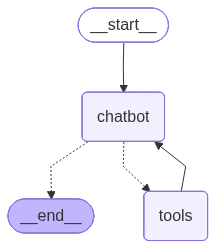

In [ ]:
# @title 직접구현한 ToolNode, tools_condition 사용버젼
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

# node추가
tool_node = ToolNode(tools)  # 도구 호출을 처리할 노드 인스턴스

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node) # 호출가능한 객체(__call__ 가능한 객체)

# edge추가
workflow.add_edge(START, 'chatbot')
# chatbot의 결과에 따라 tools_condition함수가 tools 또는 END로 분기
workflow.add_conditional_edges('chatbot', tools_condition, {'tools': 'tools', END: END})
workflow.add_edge('tools', 'chatbot')  # tools 실행 후 다시 chatbot으로 돌아가 후속 응답 생성

graph = workflow.compile()
graph

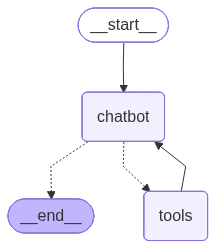

In [ ]:
# @title langgraph.prebuilt모듈의 ToolNode, tools_condition 사용버젼
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(State)

# node추가
tool_node = ToolNode(tools)  # prebuilt ToolNode 객체 생성

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node) # 호출가능한 객체(__call__)

# edge추가
workflow.add_edge(START, 'chatbot')
workflow.add_conditional_edges('chatbot', tools_condition, {'tools': 'tools', END: END})
workflow.add_edge('tools', 'chatbot')

graph = workflow.compile()
graph

In [9]:
# 그래프 실행
user_query = '미국이 그린란드 뺏으려는 상황 설명해줘'

# state = {'messages': [('human', user_query)]}
state = {'messages': [HumanMessage(content=user_query)]}

response = graph.invoke(state)
print(response['messages'][-1].content)

미국이 그린란드를 뺏으려는 상황에 대한 설명입니다.

미국은 역사적으로 그린란드를 전략적 요충지로 간주해 여러 차례 인수를 추진해왔습니다. 예를 들어, 2차 세계대전 이후 해리 트루먼 행정부는 1억 달러의 금을 제안하며 그린란드를 덴마크로부터 사들이려 했으나 거부당한 바 있습니다. 최근 도널드 트럼프 전 대통령 시절, 그린란드는 미국의 국가 안보 우선순위로 부상하며 다시 주목받았습니다.

트럼프 행정부는 덴마크 및 그린란드 측과 협의를 진행하며 광물 자원 개발을 위한 투자 계획도 검토했으며, 미국 국무장관 마르코 루비오는 덴마크 관리들과 만나 인수 방안을 논의했습니다. 군사적 측면에서도 그린란드는 중요하며, 트럼프 행정부는 군사 옵션도 항상 열려 있다고 밝혔습니다.

이러한 움직임은 북극 지역에서 미국의 영향력을 확대하고 중국, 러시아 등 경쟁국에 대응하기 위한 전략적 포석으로 해석됩니다. 다만, 덴마크는 그린란드가 자치 권한을 가진 지역임을 근거로 매각을 거부하고 있어 국제적 긴장감도 존재합니다.


In [10]:
# 그래프 실행
user_query = '랭체인 설명해줘'

# state = {'messages': [('human', user_query)]}
state = {'messages': [HumanMessage(content=user_query)]}

response = graph.invoke(state)
print(response['messages'][-1].content)

랭체인(LangChain)은 자연어 처리(NLP)와 인공지능 애플리케이션 개발을 돕기 위한 프레임워크(라이브러리)입니다. 랭체인은 주로 대형 언어 모델(LLM)을 활용하여 복잡한 대화형 AI, 검색, 문서 분석 및 생성 작업을 쉽고 효과적으로 구현하도록 설계되었습니다.

랭체인의 주요 특징은 다음과 같습니다:

1. **언어 모델 통합**: OpenAI, Hugging Face, Cohere 등 다양한 대형 언어 모델과 쉽게 연결할 수 있습니다.
2. **체인과 에이전트**: 여러 작업을 순차적으로 처리하는 '체인(chain)'을 구축해 복잡한 파이프라인을 만들 수 있고, 특정 목표를 수행하는 '에이전트(agent)'를 구축할 수 있습니다.
3. **문서 검색과 인덱싱**: 문서 내 정보를 효율적으로 검색하고 필요 시 자연어로 답변을 생성할 수 있습니다.
4. **프롬프트 관리**: 복잡한 프롬프트(모델에 입력하는 텍스트)를 쉽게 구성하고 관리할 수 있는 도구를 제공합니다.
5. **유연한 확장성**: 새로운 데이터 소스, 언어 모델, 작업 유형 등을 쉽게 추가할 수 있어 다양한 AI 앱 개발에 활용 가능합니다.

간단히 말해, 랭체인은 언어 모델을 이용한 어플리케이션 제작을 단순화하고, 모듈화하며, 개발자들이 더 빠르게 고급 AI 기능을 앱에 통합할 수 있도록 돕는 프레임워크입니다.

더 궁금한 점이 있으면 알려주세요!
